# (IID rotations) MNIST
Diagonal online Laplace with a replay buffer v.s. diagonal LoFi

In [8]:
1

1

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from rebayes.utils.utils import get_subtree

In [3]:
plt.rcParams["font.size"] = 14

In [4]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [5]:
kmode = "valid"
ksize = 200
kernel = np.ones(ksize) / ksize

## Hyperparameter optimisation

In [ ]:
%%time
%run rotating_mnist_unsorted.py uniform

Training RSGD
Memory size: 1
|   iter    |  target   |  log_lr   |
-------------------------------------
| 1         | -3.941e+0 | -11.38    |
| 2         | -2.352e+0 | -9.025    |
| 3         | -2.177e+0 | -7.787    |
| 4         | -1.113e+0 | -14.96    |
| 5         | -7.976e+0 | -14.28    |
| 6         | -1.099e+0 | -14.94    |
| 7         | -3.454e+0 | -10.72    |
| 8         | -3.61e+03 | -10.91    |
| 9         | -1e+10    | -7.556    |
| 10        | -1e+10    | -7.592    |
| 11        | -1.971e+0 | -8.001    |
| 12        | -9.087e+0 | -14.57    |
| 13        | -2.271e+0 | -8.721    |
| 14        | -3.944e+0 | -11.38    |
| 15        | -2.271e+0 | -8.721    |
| 16        | -9.087e+0 | -14.57    |
| 17        | -2.519e+0 | -9.391    |
| 18        | -2.706e+0 | -9.749    |
| 19        | -2.952e+0 | -10.12    |
| 20        | -6.962e+0 | -13.92    |
| 21        | -6.25e+03 | -13.57    |
| 22        | -5.729e+0 | -13.21    |
| 23        | -5.311e+0 | -12.86    |
| 24        | -4.931e

## Building agent

In [9]:
%%time
agents = {}

for memory, optimiser_rsgd in rsgd_optimisers.items():
    lr = np.exp(optimiser_rsgd.max["params"]["log_lr"])
    tx = optax.sgd(lr)

    agent_rsgd = rsgd.init_regression_agent(
        key, part_log_likelihood, model, X_train, tx, memory,
        lossfn=part_lossfn,
        prior_precision=1 / initial_covariance,
    )
    
    name = f"r-sgd-{memory:02}"
    agents[name] = agent_rsgd

for memory, optimiser_adam in adam_optimisers.items():
    lr = np.exp(optimiser_adam.max["params"]["log_lr"])
    tx = optax.adam(lr)

    agent_adam = rsgd.init_regression_agent(
        key, part_log_likelihood, model, X_train, tx, memory,
        lossfn=part_lossfn,
        prior_precision=1 / initial_covariance,
    )
    
    name = f"r-adam-{memory:02}"
    agents[name] = agent_adam

for memory, optimiser_lofi in lofi_optimisers.items():
    dynamics_covariance = np.exp(optimiser_lofi.max["params"]["log_dynamics_covariance"])
    dynamics_weights = 1 - np.exp(optimiser_lofi.max["params"]["log_1m_dynamics_weights"])

    agent_lofi, rfn = lofi.init_regression_agent(
        key, model, X_train,
        initial_covariance, dynamics_weights, dynamics_covariance,
        emission_cov, memory
    )
    name = f"lofi-{memory:02}"
    agents[name] = agent_lofi

CPU times: user 659 ms, sys: 72.7 ms, total: 731 ms
Wall time: 533 ms


## Run agents

In [12]:
callback = partial(callbacks.cb_reg_mc,
                ymean=ymean, ystd=ystd,
                X_test=X_test, y_test=Y_test,
                key=key,
                scale=scale,
)

In [13]:
%%time
outputs = {}
bel_agents = {}

for name_agent, agent in agents.items():
    print(name_agent)
    if "lofi" in name_agent:
        applyfn = agent.params.emission_mean_function
    else:
        applyfn = agent.apply_fn
        
    callback_agent = partial(callback, apply_fn=applyfn, agent=agent)
    bel_agent, output_agent = agent.scan(X_train, Y_train, progress_bar=True, callback=callback_agent)
    output_agent = tree_to_cpu(output_agent)
    
    outputs[name_agent] = output_agent
    bel_agents[name_agent] = bel_agent

r-sgd-01


  0%|          | 0/5458 [00:00<?, ?it/s]

r-sgd-05


  0%|          | 0/5458 [00:00<?, ?it/s]

r-sgd-10


  0%|          | 0/5458 [00:00<?, ?it/s]

r-adam-01


  0%|          | 0/5458 [00:00<?, ?it/s]

r-adam-05


  0%|          | 0/5458 [00:00<?, ?it/s]

r-adam-10


  0%|          | 0/5458 [00:00<?, ?it/s]

lofi-05


  0%|          | 0/5458 [00:00<?, ?it/s]

lofi-10


  0%|          | 0/5458 [00:00<?, ?it/s]

CPU times: user 3min 9s, sys: 4.01 s, total: 3min 13s
Wall time: 3min 37s


## Store outputs

In [14]:
import os
import pickle

dir_output = "../../figures/"
task_name = "iid-rotation"
path_base = f"../../outputs/gradually-rotating-reg"

In [15]:
optimisers = {
    "rsgd": rsgd_optimisers,
    "adam": adam_optimisers,
    "lofi": lofi_optimisers
}

In [92]:
path_target = os.path.join(path_base, f"{task_name}-outputs.pkl")
with open(path_target, "wb") as f:
    pickle.dump(outputs, f)
    
    
path_target = os.path.join(path_base, f"{task_name}-optimisers.pkl")
with open(path_target, "wb") as f:
    pickle.dump(optimisers, f)

## Plot results

In [23]:
colors = {
    "lofi-05": plt.cm.Blues(0.4),
    "lofi-10": plt.cm.Blues(0.8),
    # "lofi-20": plt.cm.Blues(0.8),
    # "lofi-50": plt.cm.Blues(0.8),
    
    "r-adam-01": plt.cm.Reds(0.4),
    "r-adam-05": plt.cm.Reds(0.65),
    "r-adam-10": plt.cm.Reds(0.8),
    
    "r-sgd-01": plt.cm.Greens(0.4),
    "r-sgd-05": plt.cm.Greens(0.65),
    "r-sgd-10": plt.cm.Greens(0.8),    
}


linestyles = {
    "lofi-05": "-",
    "lofi-10": "-",
    
    "r-adam-01": "--",
    "r-adam-05": "--",
    "r-adam-10": "--",
    
    "r-sgd-01": "dashdot",
    "r-sgd-05": "dashdot",
    "r-sgd-10": "dashdot",
}

### RMSE

In [46]:
outputs = {k:v for k,v in outputs.items() if ("50" not in k) and ("20" not in k)}

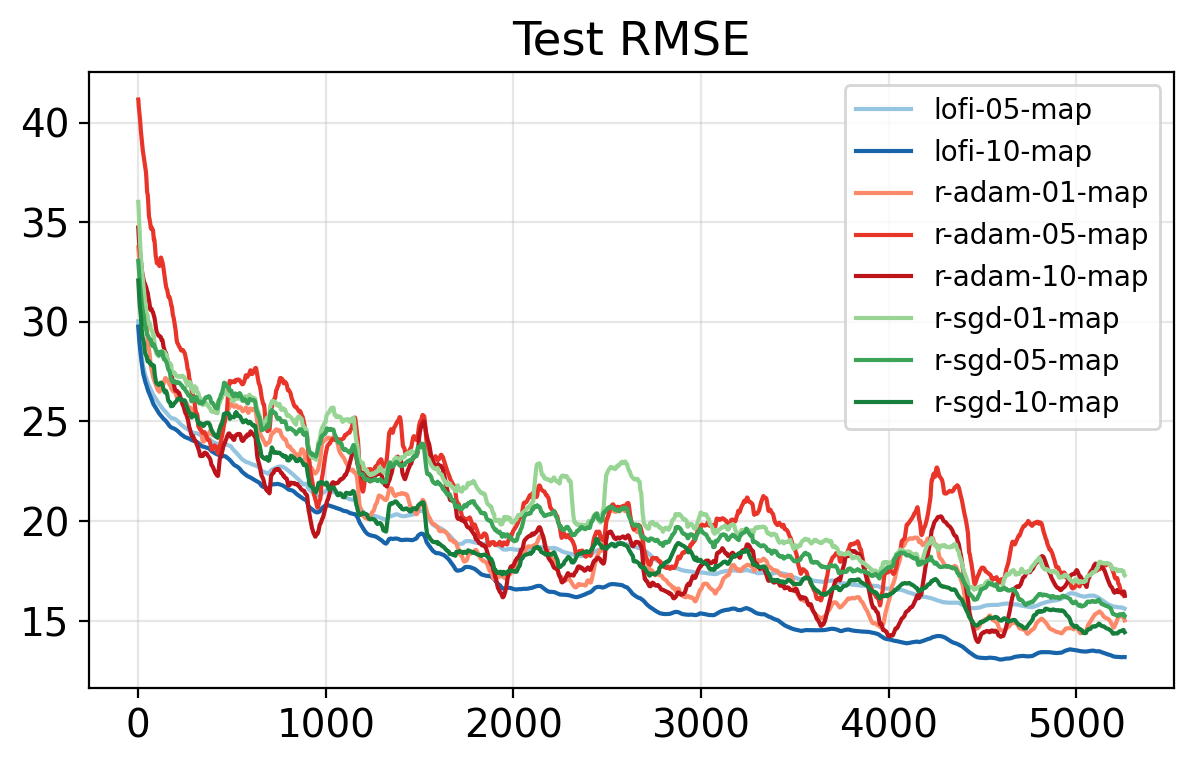

In [71]:
metric = "test-metric"
title = "Test RMSE"

outputs_metric = get_subtree(outputs, metric)
outputs_metric = jax.tree_map(lambda x: np.convolve(x, kernel, mode=kmode), outputs_metric)

fig, ax = plt.subplots(figsize=(7, 4))
for name_agent, metric_agent in outputs_metric.items():
    linestyle = linestyles[name_agent]
    plt.plot(metric_agent, label=f"{name_agent}-map", color=colors[name_agent])

# metric_agent = outputs["lofi-10"][metric]
# vmin = np.quantile(metric_agent, 0.00)
# vmax = np.quantile(metric_agent, 1.0)
# plt.ylim(vmin, vmax)

plt.title(title)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)

namefile = f"test-rmse-all.pdf"
namefile = os.path.join(dir_output, f"{task_name}-{namefile}")
plt.savefig(namefile)

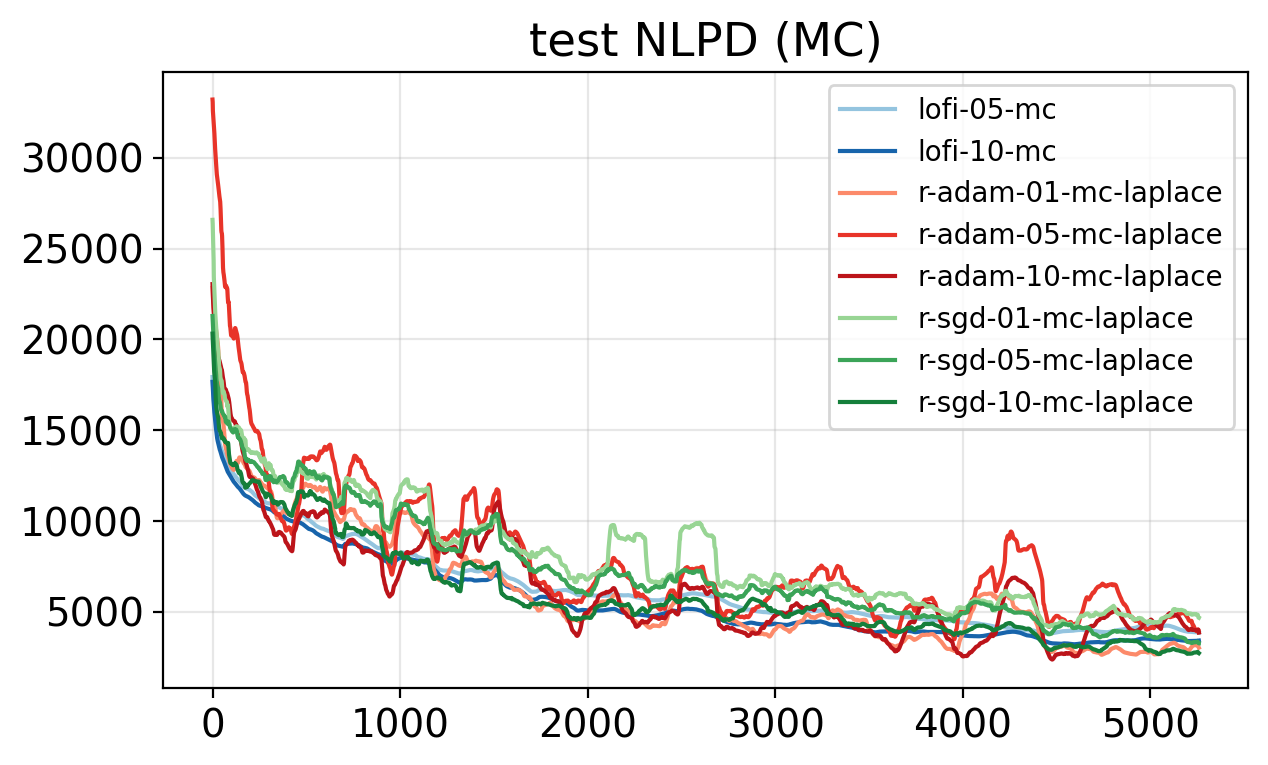

In [91]:
metric = "nlpd_test"
title = "test NLPD (MC)" # aka NLPD

outputs_metric = get_subtree(outputs, metric)
outputs_metric = jax.tree_map(lambda x: np.convolve(x, kernel, mode=kmode), outputs_metric)

fig, ax = plt.subplots(figsize=(7, 4))
for name_agent, metric_agent in outputs_metric.items():
    linestyle = linestyles[name_agent]
    extra = "-laplace" if "lofi" not in name_agent else ""
    plt.plot(metric_agent, label=f"{name_agent}-mc{extra}", color=colors[name_agent])

plt.title(title)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)

namefile = f"test-nlpd-all.pdf"
namefile = os.path.join(dir_output, f"{task_name}-{namefile}")
plt.savefig(namefile)

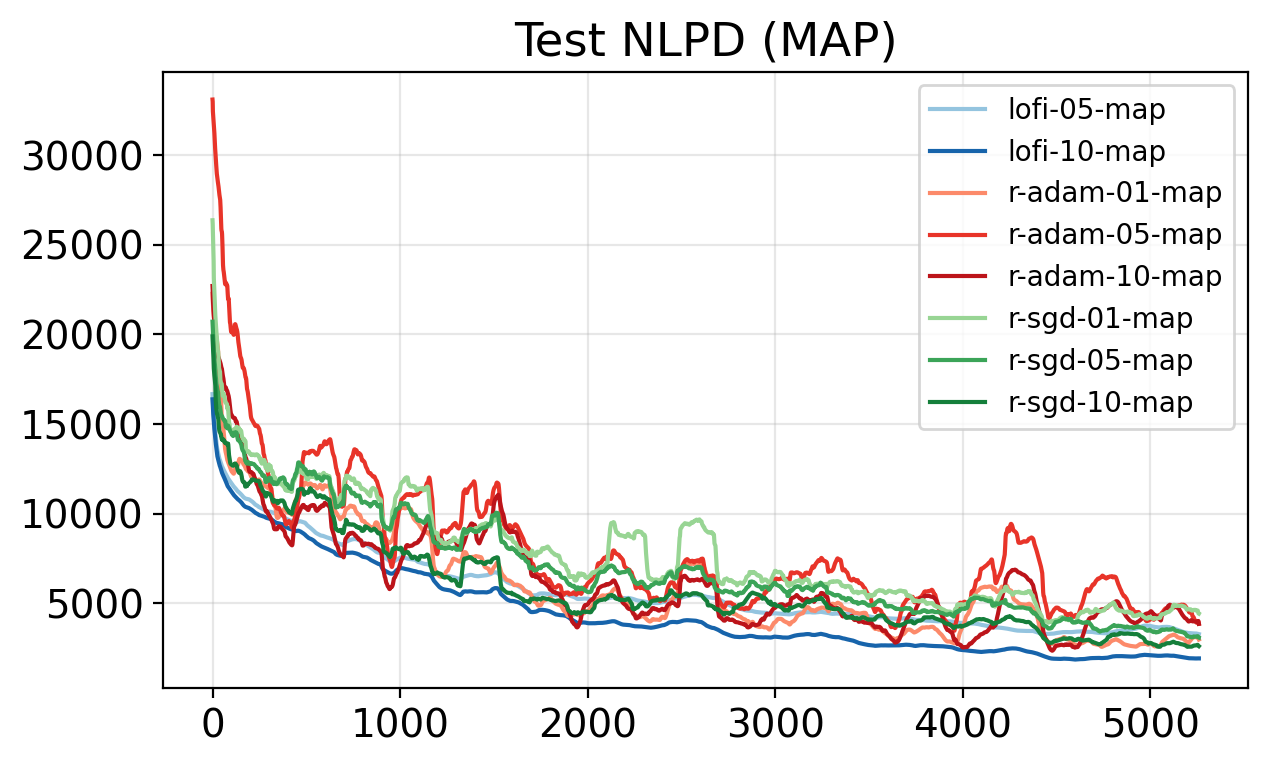

In [92]:
metric = "nll_test"
title = "Test NLPD (MAP)"

outputs_metric = get_subtree(outputs, metric)
outputs_metric = jax.tree_map(lambda x: np.convolve(x, kernel, mode=kmode), outputs_metric)

fig, ax = plt.subplots(figsize=(7, 4))
for name_agent, metric_agent in outputs_metric.items():
    linestyle = linestyles[name_agent]
    plt.plot(-metric_agent, label=f"{name_agent}-map", color=colors[name_agent])

plt.title(title)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)

namefile = f"test-nll-all.pdf"
namefile = os.path.join(dir_output, f"{task_name}-{namefile}")
plt.savefig(namefile)

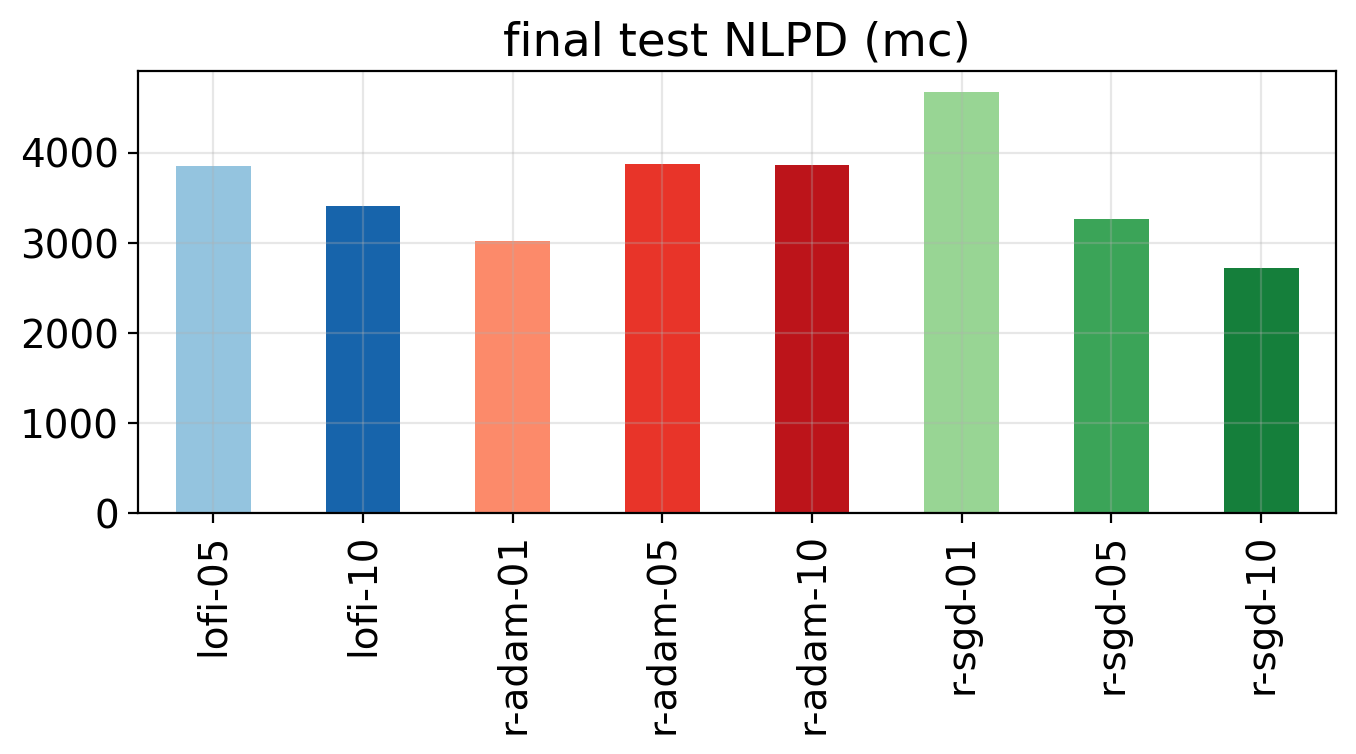

In [52]:
fig, ax = plt.subplots(figsize=(7, 4))

metric = "nlpd_test"

outputs_metric = get_subtree(outputs, metric)
outputs_metric = jax.tree_map(lambda x: np.convolve(x, kernel, mode=kmode), outputs_metric)

pd.DataFrame(outputs_metric).iloc[-1].plot(kind="bar", color=colors.values(), ax=ax)
plt.title("final test NLPD (mc)")
plt.grid(alpha=0.3)
plt.tight_layout()
namefile = f"test-nlpd-all-final.pdf"
namefile = os.path.join(dir_output, f"{task_name}-{namefile}")
plt.savefig(namefile)

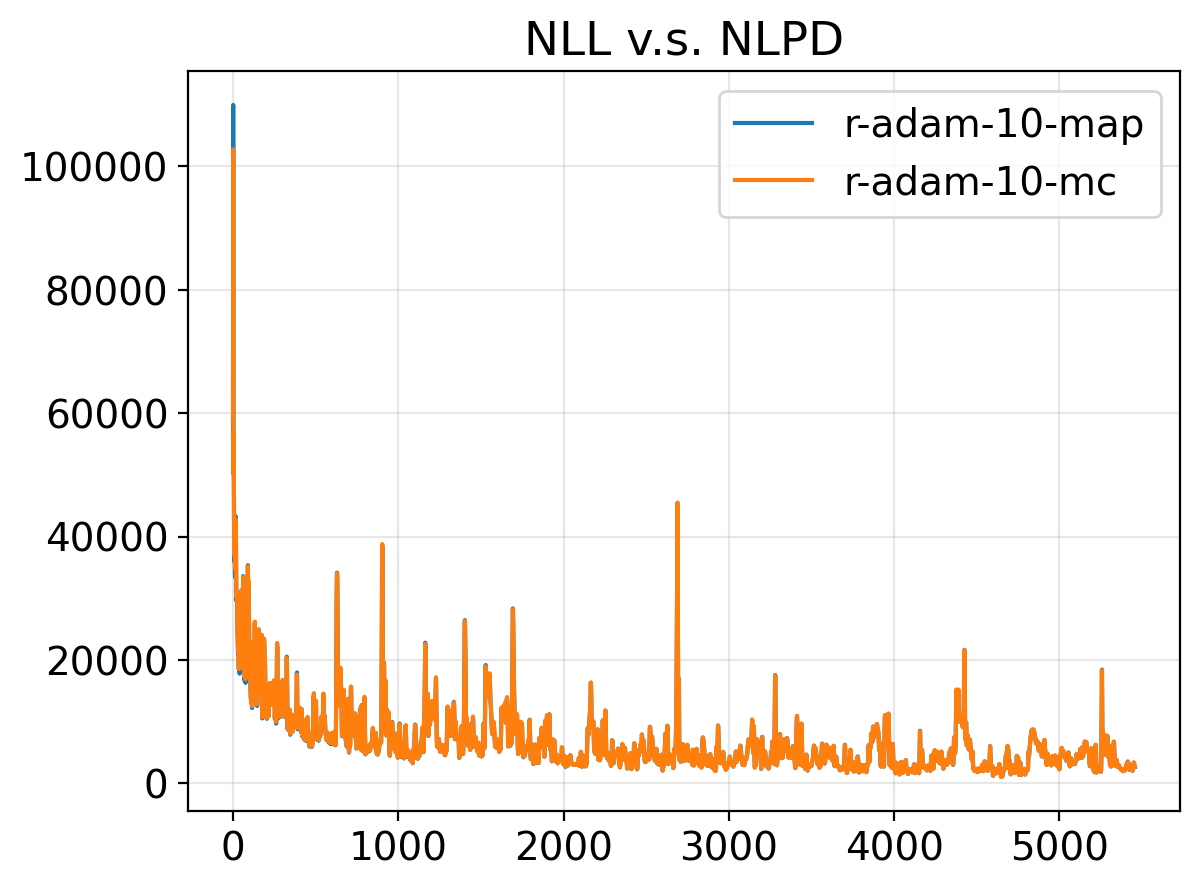

In [65]:
plt.title("NLL v.s. NLPD")
agent = "r-adam-10"
plt.plot(-outputs[agent]["nll_test"], label=f"{agent}-map")
plt.plot(outputs[agent]["nlpd_test"], label=f"{agent}-mc")
plt.legend()
plt.grid(alpha=0.3)